# Imports

In [1]:
!pip install -q econml rpy2 dowhy dask[dataframe]

In [2]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

In [3]:
from rpy2.robjects import r as R
import pandas as pd

%load_ext rpy2.ipython
%R install.packages("Matching")
%R library(Matching)
%R data(lalonde)
%R -o lalonde
lalonde.to_csv("lalonde.csv", index=False)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpwAGvNs/downloaded_packages’


##  Matching (Version 4.10-14, Build Date: 2023-09-13)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from econml.dml import LinearDML, CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import dowhy.api

# Load Data

In [5]:
# LaLonde DataFrame
lalonde = pd.read_csv("lalonde.csv")
lalonde.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [6]:
# DoWhy DataFrame
do_df = lalonde.causal.do(
    x='treat',
    outcome='re78',
    common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
    variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd',
                    'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'}
)
do_df.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat,propensity_score,weight
0,18,8,1,0,0,1,0.00,0.00,0.00,1,1,1,0.386938,2.584394
1,24,11,0,0,0,1,2669.73,1468.38,10361.70,0,0,0,0.600721,1.664667
2,25,12,1,0,0,0,0.00,0.00,3418.10,1,1,0,0.461254,2.168001
3,17,7,1,0,0,1,0.00,0.00,3023.88,1,1,1,0.397396,2.516381
4,26,10,1,0,0,1,0.00,0.00,3931.24,1,1,0,0.624270,1.601871


In [7]:
# Define the data
X = lalonde[['age', 'educ', 'black', 'hisp', 'married', 'nodegr']]
D = lalonde['treat'].values  # Convert to 1D array
y = lalonde['re78'].values   # Convert to 1D array

In [8]:
# Define models (parametric and non-parametric)
parametric_model_y = LinearRegression()
parametric_model_t = LogisticRegression()

non_parametric_model_y = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
non_parametric_model_t = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

# Perform DML with different models
ates_dict = {}
residuals_dict = {}

# Manual Implementation

In [9]:
# DML implementation (parametric or non-parametric)
def dml(X, D, y, model_y, model_t, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    ates = []
    residuals = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        D_train, D_test = D[train_index], D[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estimate nuisance function g(X) for the outcome
        model_y.fit(X_train, y_train)
        g_X_test = model_y.predict(X_test)

        # Estimate nuisance function m(X) for the treatment
        model_t.fit(X_train, D_train)
        if isinstance(model_t, LogisticRegression) or isinstance(model_t, RandomForestClassifier):
            m_X_test = model_t.predict_proba(X_test)[:, 1]
        else:
            m_X_test = model_t.predict(X_test)

        # Compute residuals for y and D
        y_residual_test = y_test - g_X_test
        D_residual_test = D_test - m_X_test
        residuals.append((y_residual_test, D_residual_test))

        # Regress the residuals of y on the residuals of D to estimate the causal effect
        model_effect = LinearRegression()
        model_effect.fit(D_residual_test.reshape(-1, 1), y_residual_test)
        treatment_effect = model_effect.predict(D_residual_test.reshape(-1, 1))

        # Calculate the average treatment effect
        ate = np.mean(treatment_effect)
        ates.append(ate)

    avg_ate = np.mean(ates)
    return avg_ate, residuals

In [10]:
# Manual DML with parametric models
ate, residuals = dml(X, D, y, parametric_model_y, parametric_model_t)
ates_dict['Manual Parametric DML'] = ate
residuals_dict['Manual Parametric DML'] = residuals

In [11]:
# Manual DML with non-parametric models
ate, residuals = dml(X, D, y, non_parametric_model_y, non_parametric_model_t)
ates_dict['Manual Non-Parametric DML'] = ate
residuals_dict['Manual Non-Parametric DML'] = residuals

# EconML Implementation

In [12]:
# DML using econml (parametric or non-parametric)
def econml_dml(X, D, y, model_y, model_t, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    ates = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        D_train, D_test = D[train_index], D[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create the CausalForestDML estimator
        estimator = CausalForestDML(
            model_y=model_y,
            model_t=model_t,
            discrete_treatment=True,
            n_estimators=100,
            min_samples_leaf=5,
            max_depth=None,
            random_state=123,
            criterion="mse",  # or "het" for heterogeneity criterion
            verbose=0,
            n_jobs=-1
        )

        # Fit the estimator
        estimator.fit(y_train, D_train, X=X_train)

        # Estimate the treatment effect on the test set
        treatment_effect = estimator.effect(X_test)

        # Calculate the average treatment effect
        ate = np.mean(treatment_effect)
        ates.append(ate)

    avg_ate = np.mean(ates)
    return avg_ate

In [13]:
# econml DML with parametric models
ate = econml_dml(X, D, y, parametric_model_y, parametric_model_t)
ates_dict['econml Parametric DML'] = ate

In [14]:
# econml DML with non-parametric models
ate = econml_dml(X, D, y, non_parametric_model_y, non_parametric_model_t)
ates_dict['econml Non-Parametric DML'] = ate

# Results

In [17]:
# Visualize results
def visualize_results(ates_dict, residuals_dict):
    # Print out ATEs
    for key, ate in ates_dict.items():
        print(f"{key} Estimated Average Treatment Effect (ATE): {ate}")

    # Compare ATEs
    print("\n")
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(ates_dict.keys()), y=list(ates_dict.values()), hue=list(ates_dict.keys()), palette='viridis', errorbar=None)
    plt.title('Comparison of Estimated ATEs')
    plt.ylabel('Average Treatment Effect (ATE)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    print("\n")

    # Residual distributions
    for key, residuals in residuals_dict.items():
        y_residuals = np.concatenate([r[0] for r in residuals])
        D_residuals = np.concatenate([r[1] for r in residuals])

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(y_residuals, kde=True, color='blue', bins=30)
        plt.title(f'{key} - Outcome Residuals Distribution', fontsize=14, pad=20)

        plt.subplot(1, 2, 2)
        sns.histplot(D_residuals, kde=True, color='green', bins=30)
        plt.title(f'{key} - Treatment Residuals Distribution', fontsize=14, pad=20)

        plt.tight_layout(pad=3.0)
        plt.subplots_adjust(top=0.85)
        plt.show()

Manual Parametric DML Estimated Average Treatment Effect (ATE): 25.53792929518006
Manual Non-Parametric DML Estimated Average Treatment Effect (ATE): 46.62079554527354
econml Parametric DML Estimated Average Treatment Effect (ATE): 1480.2911505709978
econml Non-Parametric DML Estimated Average Treatment Effect (ATE): 1658.866271278263




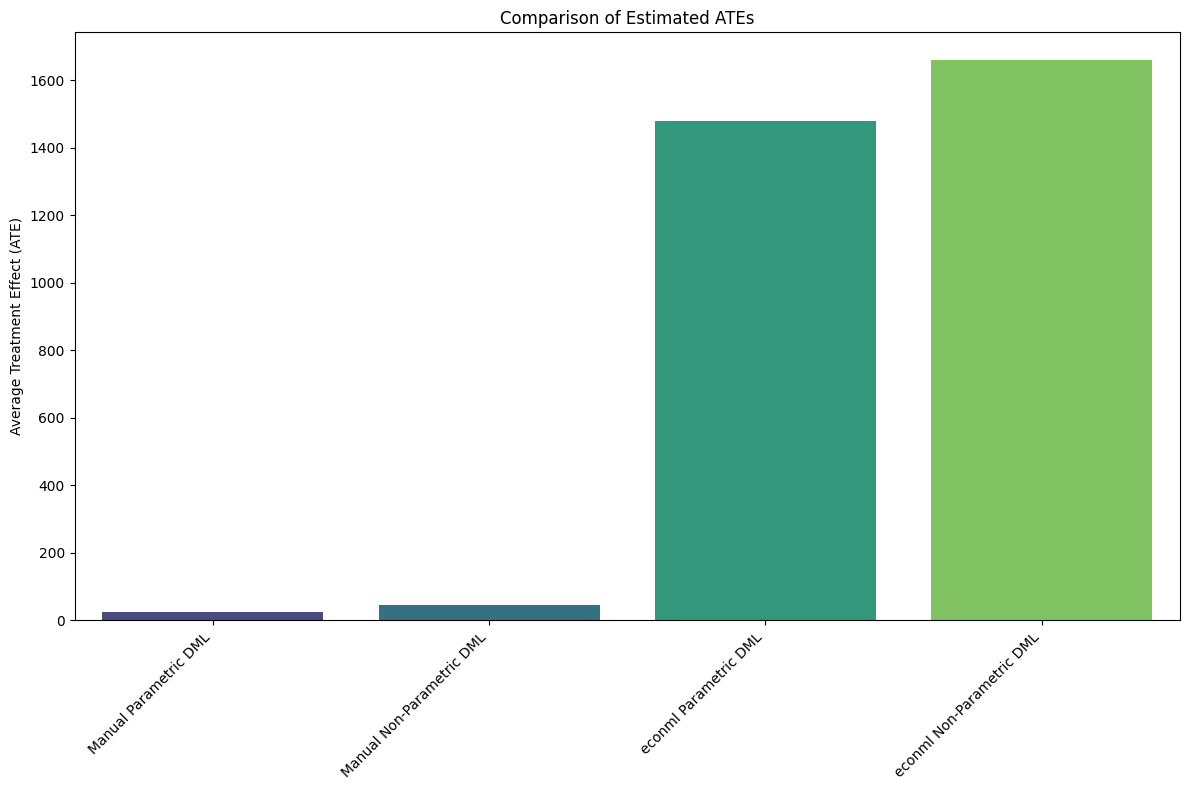

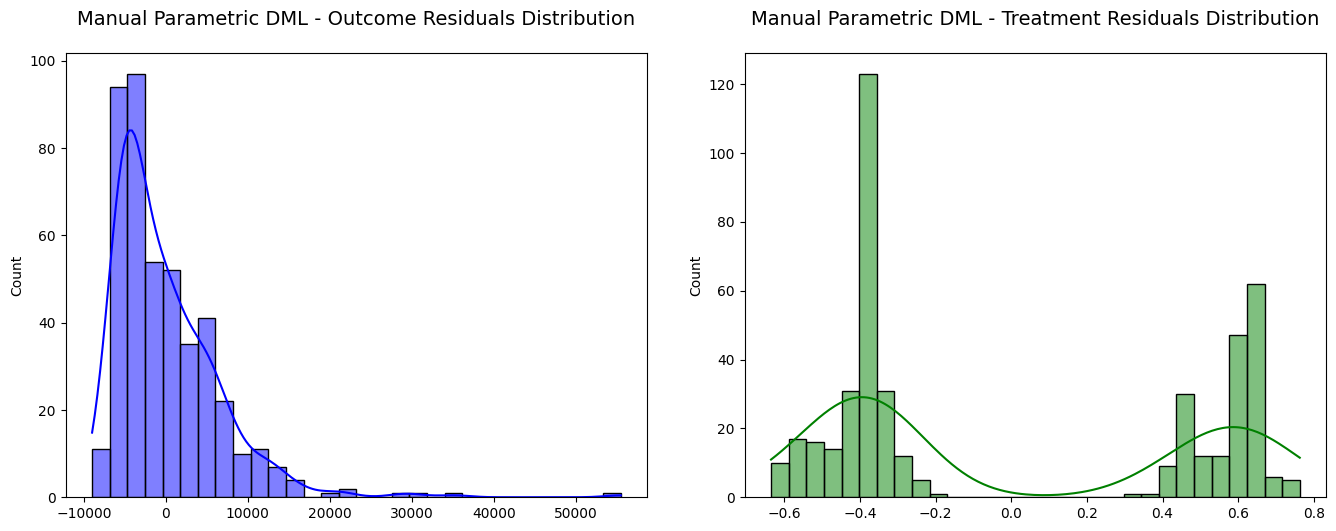

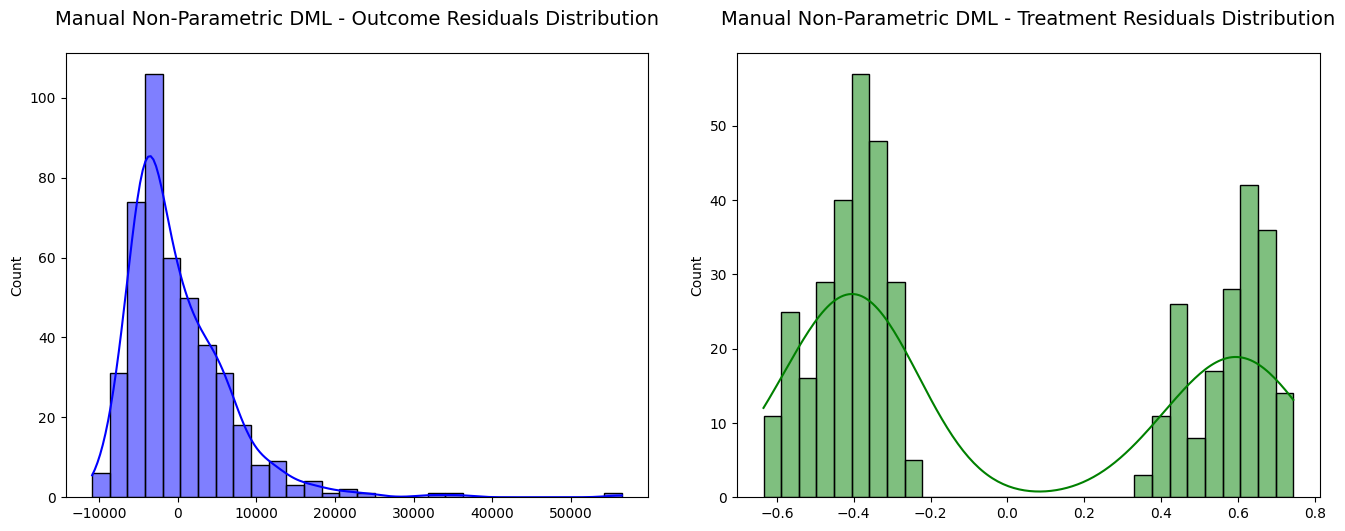

In [18]:
# Visualize and compare results
visualize_results(ates_dict, residuals_dict)